In [1]:
import statsmodels.api as sm
import scipy
from scipy import power
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.power import TTestPower
import pandas as pd
import numpy as np
import random
from statsmodels.stats.proportion import proportion_effectsize
import matplotlib.pyplot as plt
import math

## Допустим у нас есть таблица по пользовательским платам и мы решили протестировать новую фичу, которая предположительно поднимет пользовательскую плату в среднем на 0.3 единицы валюты 

In [2]:
userpay_data = pd.DataFrame(columns = ['user_id', 'payment'])
userpay_data['user_id'] = np.arange(1, 5001)
arr = []
for i in range(5000):
    x = random.gauss(13, 2.3)
    arr.append(x)
userpay_data['payment'] = np.array(arr)

In [3]:
userpay_data

,user_id,payment
0,1,6.968741
1,2,12.292683
2,3,15.346669
3,4,10.901041
4,5,12.953999
...,...,...
4995,4996,8.108694
4996,4997,16.151424
4997,4998,11.050839
4998,4999,11.195286


<Axes: >

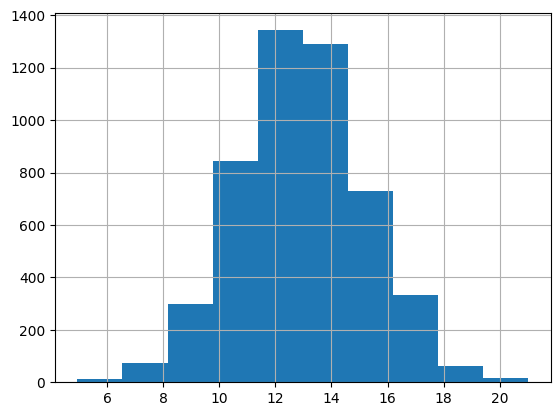

In [4]:
userpay_data['payment'].hist()

In [5]:
userpay_data['payment'].mean()

12.946947586983805

# Итак, нам понадобится >= 924 наблюдений, возьмем 1000

In [6]:
TTestIndPower().solve_power(alpha = 0.05, power = 0.8, effect_size = (13.3 - 13)/2.3, alternative = 'two-sided')

923.638516763391

## Разобьем пользователей на  тестовую и контрольную группы

In [7]:
userpay_data['group'] = random.choices(['Test', 'Controll'], weights = [50, 50], k = 5000)
userpay_data

,user_id,payment,group
0,1,6.968741,Controll
1,2,12.292683,Controll
2,3,15.346669,Controll
3,4,10.901041,Test
4,5,12.953999,Controll
...,...,...,...
4995,4996,8.108694,Test
4996,4997,16.151424,Controll
4997,4998,11.050839,Test
4998,4999,11.195286,Test


In [8]:
df_test = userpay_data[userpay_data['group'] == 'Test'].sample(1000)
df_controll = userpay_data[userpay_data['group'] == 'Controll'].sample(1000)

### Наша контрольная группа 

In [9]:
arr1 = []
for i in range(1000):
    x = random.gauss(13, 2.3)
    arr1.append(x)
df_controll['payment'] = np.array(arr1)

### Наша тестовая группа

In [10]:
arr2 = []
for i in range(1000):
    x = random.gauss(13.31, 2.3)
    arr2.append(x)
df_test['payment'] = np.array(arr2)

<Axes: >

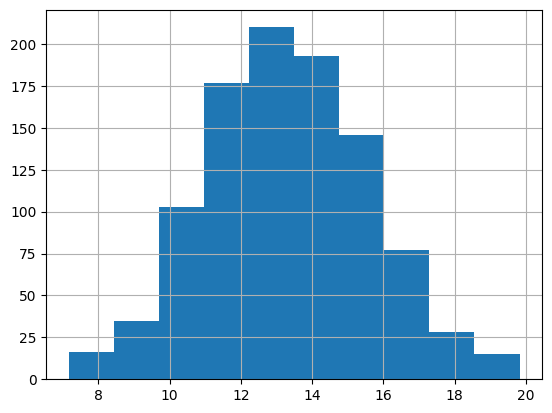

In [11]:
df_test['payment'].hist()

In [12]:
t_score, p_value, dgf = sm.stats.ttest_ind(df_test['payment'], df_controll['payment'])
print(t_score, '{:.12f}'.format(p_value), dgf)

2.203826832381678 0.027650210974 1998.0


In [13]:
if p_value > 0.025:
    print('T-Тест ПОКАЗАЛ , ЧТО Р-VALUE > 0.025, А ЗНАЧИТ МЫ ОТКЛОНЯЕМ АЛЬТЕРНАТИВНУЮ ГЕПОТЕЗУ В ПОЛЬЗУ НУЛЕВОЙ')
else:
    print('Т-тест показал p-value меньше 0.025 а значит мы можем отвергнуть нулевую гепотезу(фича не сработала и средние выборок равны) в пользу альтернативной(фича сработала и средние выборок значимо различаются)на уровне статистической значимости в 0.95')

Т-тест показал p-value меньше 0.025 а значит мы можем отвергнуть нулевую гепотезу(фича не сработала и средние выборок равны) в пользу альтернативной(фича сработала и средние выборок значимо различаются)на уровне статистической значимости в 0.95


## В случае если фича сработает в обратном направлении(уменьшит среднюю плату) т-значение станет отрицательным и мы получим сигнал о том, что фичу лучше не вводить

In [14]:
arr3 = []
for i in range(1000):
    x = random.gauss(12.69, 2.3)
    arr3.append(x)
df_test['payment2'] = np.array(arr3)

In [15]:
t_score, p_value, dgf = sm.stats.ttest_ind(df_test['payment2'], df_controll['payment'])
print(t_score, '{:.12f}'.format(p_value), dgf)

-3.9228705397029593 0.000090457173 1998.0


# Следущий тест будет также на равенство средних, но с использованием стратификации

### Датафрейм будет содержать идентификатор пользователя, информацию о покупке и страту, к которой пользователь принадлежит;
### каждая страта будет отличаться по средней плате на пользователя и количеству пользователей

In [16]:
a, b, c = pd.DataFrame(columns = ['uid', 'payment', 'strat']), pd.DataFrame(columns = ['uid', 'payment', 'strat']), pd.DataFrame(columns = ['uid', 'payment', 'strat'])
a['uid'], a['payment'], a['strat'] = np.arange(1000), np.random.normal(21, 2.2, 1000), 'blue'
b['uid'], b['payment'], b['strat'] = np.arange(1000, 3700), np.random.normal(45, 2.2, 2700), 'green'
c['uid'], c['payment'], c['strat'] = np.arange(3700, 7200), np.random.normal(34, 2.2, 3500), 'red'

user_sales = pd.concat([a,b,c], axis = 0)

In [17]:
user_sales

,uid,payment,strat
0,0,22.759162,blue
1,1,18.352519,blue
2,2,18.651325,blue
3,3,20.751371,blue
4,4,20.514542,blue
...,...,...,...
3495,7195,33.258475,red
3496,7196,40.769693,red
3497,7197,32.678330,red
3498,7198,33.247803,red


In [18]:
user_sales['payment'].std()

8.313677505205119

### Вычислим размер групп

In [19]:
group_size = math.ceil(TTestIndPower().solve_power(alpha = 0.05, power = 0.8, 
                                                   effect_size = (0.7/user_sales['payment'].std()), alternative = 'two-sided')
)
group_size

2216

### Разобьем пользователей на группы

In [20]:
user_sales['group'] = random.choices(['test', 'control'], weights = [50, 50], k = 7200)
user_sales

,uid,payment,strat,group
0,0,22.759162,blue,test
1,1,18.352519,blue,control
2,2,18.651325,blue,control
3,3,20.751371,blue,test
4,4,20.514542,blue,test
...,...,...,...,...
3495,7195,33.258475,red,test
3496,7196,40.769693,red,test
3497,7197,32.678330,red,test
3498,7198,33.247803,red,control


### Отдельно выпишем веса страт и их размеры внутри групп

In [21]:
weights = user_sales.groupby('strat')['payment'].count()/len(user_sales)
weights

strat
blue     0.138889
green    0.375000
red      0.486111
Name: payment, dtype: float64

In [22]:
strat_sizes = pd.Series({'blue':math.ceil(weights[0]*group_size),
                         'green':math.ceil(weights[1]*group_size),
                         'red':math.ceil(weights[2]*group_size)})
strat_sizes

C:\Users\cours\AppData\Local\Temp\ipykernel_131264\1264020507.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  strat_sizes = pd.Series({'blue':math.ceil(weights[0]*group_size),
C:\Users\cours\AppData\Local\Temp\ipykernel_131264\1264020507.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'green':math.ceil(weights[1]*group_size),
C:\Users\cours\AppData\Local\Temp\ipykernel_131264\1264020507.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser

blue      308
green     831
red      1078
dtype: int64

### Проведем стратифицированное сэмплирование

In [23]:
user_sales_control = pd.concat([user_sales.query("group == 'control' & strat == 'blue'").sample(strat_sizes['blue']),
                               user_sales.query("group == 'control' & strat == 'green'").sample(strat_sizes['green']),
                               user_sales.query("group == 'control' & strat == 'red'").sample(strat_sizes['red'])], axis = 0)

user_sales_test = pd.concat([user_sales.query("group == 'test' & strat == 'blue'").sample(strat_sizes['blue']),
                               user_sales.query("group == 'test' & strat == 'green'").sample(strat_sizes['green']),
                               user_sales.query("group == 'test' & strat == 'red'").sample(strat_sizes['red'])], axis = 0)                           

### Благодаря стратификации чувствительность теста должна была вырасти, поэтому имитируем увеличение средней платы не на 0.7,
### а на 0.4 и посмотрим задетектирует ли он эффект меньше заложенного изначально

In [24]:
user_sales_test['payment'] = user_sales_test['payment'] + 0.4

### Расчитаем стратифицированное среднее и стратифицированную дисперсию в каждой группе

In [25]:
strat_mean_control = sum(user_sales_control.groupby('strat')['payment'].mean()*weights)
strat_mean_test = sum(user_sales_test.groupby('strat')['payment'].mean()*weights)
strat_var_control = sum(user_sales_control.groupby('strat')['payment'].var()*weights)
strat_var_test = sum(user_sales_test.groupby('strat')['payment'].var()*weights)
(strat_mean_control, strat_mean_test) , (strat_var_control, strat_var_test)

((36.25271521254324, 36.7122937094133), (4.699100924590441, 4.908679711615718))

In [26]:
tscore = (strat_mean_test - strat_mean_control)/(strat_var_control/len(user_sales_control) + strat_var_test/len(user_sales_test))**0.5

In [27]:
pval = 2*(1 - scipy.stats.norm.cdf(np.abs(tscore)))

In [28]:
if pval < 0.025:
    print('p-значение меньше альфа, значит с вероятностью 95%  распределения метрики в группах статистически различаются', tscore, '{:.12f}'.format(pval))
else:
    print('Различие между группами статистически не значимо на уровне 95% ')

p-значение меньше альфа, значит с вероятностью 95%  распределения метрики в группах статистически различаются 6.981214910078181 0.000000000003


# Проведем еще один тест, но на конверсию

In [29]:
user_conversion = pd.DataFrame(columns = ['user_id', 'action'])
user_conversion['user_id'] = np.arange(3000)
user_conversion['action'] = np.array(random.choices([0,1], weights = [90, 10], k = 3000))

In [30]:
proportion_effectsize(0.14, 0.1)

0.1234928990685823

# Возьмем 1040 наблюдений

In [31]:
TTestIndPower().solve_power(alpha = 0.05, power = 0.8, effect_size = 0.1234928990685823, alternative = 'two-sided')

1030.2865281274026

# Определим группы для пользователей

In [32]:
user_conversion['group'] = random.choices(['Test', 'Controll'], weights = [50,50], k = 3000)

In [33]:
conv_test = user_conversion[user_conversion['group'] == 'Test'].sample(1040)
conv_controll = user_conversion[user_conversion['group'] == 'Controll'].sample(1040)

## Получаем новые данные

In [34]:
conv_controll['action'] = np.array(random.choices([0,1], weights = [90, 10], k = 1040))
conv_test['action'] = np.array(random.choices([0,1], weights = [86.3, 14.7], k = 1040))

## Проводим т-тест 

In [35]:
t, pvalue, dgfr = sm.stats.ttest_ind(conv_test['action'],conv_controll['action'])
t, pvalue, dgfr

(3.3684941483013664, 0.0007695948294887085, 2078.0)

## Проведя z-тест для пропорций получим примерно такие же результаты

In [36]:
sm.stats.proportions_ztest([conv_test[conv_test['action'] == 1]['action'].count(), 
                            conv_controll[conv_controll['action'] == 1]['action'].count()],
                            [conv_test['action'].count(), conv_controll['action'].count()])

(3.3609511751623593, 0.0007767455494411556)

In [37]:
if pvalue < 0.025:
    print('Итак мы получили статистически значимые различия и можем отвергнуть нулевую гепотезу в пользу альтернативной со статистической значимостью 0.95, t-значение сдвинулось вправо - то есть среднее в распределении увеличилось по сравнению с первоначальным, а значит количество единиц выросло')
else:
    print('P-VALUE> 0.025 А ЗНАЧИТ СТАТИСТИЧЕСКИ ЗНАЧИМЫХ РАЗЛИЧИЙ НЕ БЫЛО ОБНАРУЖЕНО И ВОЗМОЖНОСТИ ОТВЕРГНУТЬ НУЛЕВУЮ ГЕПОТЕЗУ НЕТ')

Итак мы получили статистически значимые различия и можем отвергнуть нулевую гепотезу в пользу альтернативной со статистической значимостью 0.95, t-значение сдвинулось вправо - то есть среднее в распределении увеличилось по сравнению с первоначальным, а значит количество единиц выросло


## Проведем Cuped тест

### Сгенерируем искусственную выборку

In [38]:
A_before = np.random.normal(15, 1.2, 1000)
B_before = np.random.normal(15, 1.2, 1000)
A_after = [x + random.gauss(0, 0.5) for x in A_before]
B_after = [x + random.gauss(0, 0.5) + 0.65 for x in B_before]

### Расчитаем коэффициент тета

In [39]:
theta = np.cov(A_before + B_before, 
               np.array(A_after).flatten() + np.array(B_after).flatten())[0,1]/np.var(A_before+B_before)

In [40]:
theta

0.967849161322709

In [41]:
A_cup = A_after - theta*A_before
B_cup = B_after - theta*B_before

### Проведем т-тест

In [42]:
if sm.stats.ttest_ind(B_cup, A_cup)[1] > 0.025:
    print('р-значение больше уровня значимости, принимаем нулевую гепотезу', 'p-значение=', '{:.12f}'.format(sm.stats.ttest_ind(B_cup, A_cup)[1]))
else:
    print('р-значение меньше уровня значимости принимаем альтернативную гепотезу', 'p-значение=', '{:.12f}'.format(sm.stats.ttest_ind(B_cup, A_cup)[1]))

р-значение меньше уровня значимости принимаем альтернативную гепотезу p-значение= 0.000000000000


## Проведем много тестов и посмотрим как себя ведут мощность и уровень значимости

In [43]:
from tqdm import tqdm
alpha_no_effect, no_effect = 0,0
for _ in tqdm(range(50000)):
    A_before = np.random.normal(15, 1.1, 1000)
    B_before = np.random.normal(15, 1.1, 1000)
    A_after = [x + random.gauss(0, 0.49) for x in A_before]
    B_after = [x + random.gauss(0, 0.49) for x in B_before]
    theta = np.cov(A_before + B_before, 
               np.array(A_after).flatten() + np.array(B_after).flatten())[0,1]/np.var(A_before+B_before)
    A_cup = A_after - theta*A_before
    B_cup = B_after - theta*B_before
    if sm.stats.ttest_ind(B_cup, A_cup)[1] > 0.05:
        no_effect +=1
    else:
        alpha_no_effect+=1
from tqdm import tqdm
beta_effect, power_effect = 0,0
for _ in tqdm(range(50000)):
    A_before = np.random.normal(15, 1.1, 1000)
    B_before = np.random.normal(15, 1.1, 1000)
    A_after = [x + random.gauss(0, 0.49) for x in A_before]
    B_after = [x + random.gauss(0, 0.49) + 0.5 for x in B_before]
    theta = np.cov(A_before + B_before, 
               np.array(A_after).flatten() + np.array(B_after).flatten())[0,1]/np.var(A_before+B_before)
    A_cup = A_after - theta*A_before
    B_cup = B_after - theta*B_before
    if sm.stats.ttest_ind(B_cup, A_cup)[1] > 0.05:
       beta_effect +=1
    else:
        power_effect +=1
print(' доля верно принятых нулевых гепотез:', no_effect/50000, '\n доля ошибок 1 рода:', alpha_no_effect/50000,
       '\n доля ошибок 2 рода:',  beta_effect/50000, '\n доля верно отвергнутых нулевых гепотез:', power_effect/50000)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:00<00:00, 415.85it/s]

 доля верно принятых нулевых гепотез: 0.95024 
 доля ошибок 1 рода: 0.04976 
 доля ошибок 2 рода: 0.0 
 доля верно отвергнутых нулевых гепотез: 1.0


# Проведем последний тест на равенство медиан с использованием Bootstrap

## Сгенерируем массив, состоящий из случайных 60 чисел от 1 до 10

In [44]:
sample = np.random.randint(1, 10, 60)

In [45]:
sample

array([2, 5, 2, 2, 1, 8, 7, 3, 9, 4, 2, 6, 1, 1, 2, 4, 1, 7, 2, 1, 9, 3,
       1, 5, 9, 7, 8, 5, 8, 3, 4, 5, 6, 8, 3, 5, 9, 5, 1, 7, 8, 4, 4, 9,
       6, 9, 7, 7, 9, 2, 2, 5, 4, 5, 6, 2, 9, 9, 9, 3])

## Напишем функцию для бутстрапирования и применим к раннее созданному массиву

In [46]:
def getbootstrap(arr, N):
    n = arr.size
    boot = np.random.choice(arr, size = (n, N), replace = True)
    return boot

In [47]:
boot_sample = getbootstrap(sample, 100000)

In [48]:
boot_sample

array([[4, 3, 9, ..., 2, 5, 5],
       [9, 2, 8, ..., 8, 4, 5],
       [8, 9, 9, ..., 5, 2, 4],
       ...,
       [3, 7, 5, ..., 9, 7, 1],
       [5, 9, 6, ..., 2, 2, 1],
       [5, 1, 6, ..., 4, 2, 4]])

## Найдем распределение медианы в бутстрап-сэмпле

In [49]:
boot_sample_median = np.median(boot_sample, axis = 0)

## Напишем еще одну функцию для вычисления 95%-го доверительного интервала интервала и применим ее к выборке медиан

In [50]:
def confidence_interval(array):
    left = np.quantile(array, 0.05/2)
    right = np.quantile(array, 1 - 0.05/2)
    return left, right

In [51]:
print('95% значений медианы лежат в интервале', confidence_interval(boot_sample_median))

95% значений медианы лежат в интервале (4.0, 6.0)


## Создадим еще один сэмпл, применим к нему функцию для бутстрапа и, затем, найдем распределение медиан и 95%-й доверительный интервал для этого распределения

In [52]:
sample2 = np.random.randint(100, 150, 60)

In [53]:
boot_sample2 = getbootstrap(sample2, 100000)

In [54]:
boot_sample2_median = np.median(boot_sample2, axis = 0)
boot_sample2_median

array([130., 126., 118., ..., 130., 121., 118.])

In [55]:
print('У этого распределения 95% всех начений медианы лежат между', confidence_interval(boot_sample2_median))


У этого распределения 95% всех начений медианы лежат между (116.5, 132.0)


## Теперь найдем 95%-й доверительный интервал для разностей медиан этих двух распределений

In [56]:
confidence_interval(boot_sample2_median - boot_sample_median)

(111.5, 127.0)

## Нуль не входит в этот интервал а значит медианы этих распределений с 95% вероятностью не равны

(array([1.8900e+02, 3.2650e+03, 1.7939e+04, 9.9770e+03, 1.7060e+04,
        3.0887e+04, 1.4196e+04, 6.1900e+03, 2.8500e+02, 1.2000e+01]),
 array([106.  , 108.85, 111.7 , 114.55, 117.4 , 120.25, 123.1 , 125.95,
        128.8 , 131.65, 134.5 ]),
 <BarContainer object of 10 artists>)

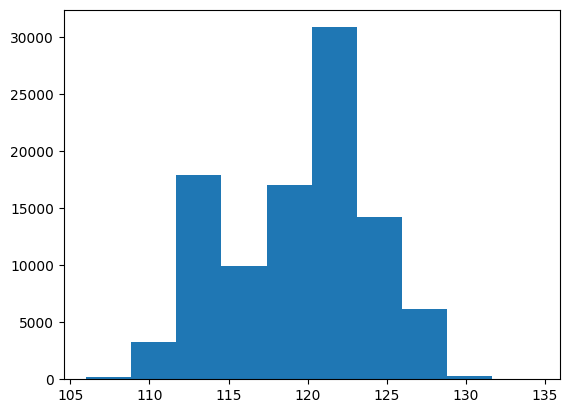

In [57]:
plt.hist(boot_sample2_median - boot_sample_median)

((array([1.5000e+01, 6.5100e+02, 5.8600e+02, 1.6837e+04, 7.6790e+03,
         6.2113e+04, 4.3540e+03, 6.5990e+03, 5.6900e+02, 5.9700e+02]),
  array([2.  , 2.55, 3.1 , 3.65, 4.2 , 4.75, 5.3 , 5.85, 6.4 , 6.95, 7.5 ]),
  <BarContainer object of 10 artists>),
 (array([2.4500e+02, 4.8860e+03, 1.7339e+04, 9.7460e+03, 1.5976e+04,
         3.1973e+04, 1.4622e+04, 5.1580e+03, 4.3000e+01, 1.2000e+01]),
  array([112. , 114.7, 117.4, 120.1, 122.8, 125.5, 128.2, 130.9, 133.6,
         136.3, 139. ]),
  <BarContainer object of 10 artists>))

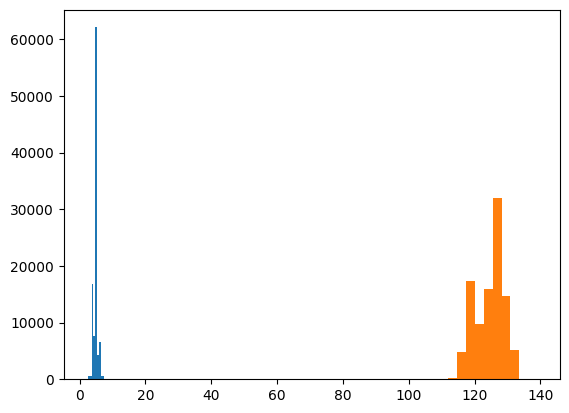

In [58]:
plt.hist(boot_sample_median), plt.hist(boot_sample2_median)

In [59]:
theta_hat = np.mean(sample)
std_hat = np.mean(sample)

## Также можно посчитать 95%-й t-процентильный интервал для средней первого распределения

In [60]:
sample_t_boot = np.mean(boot_sample-theta_hat, axis=0)/np.std(boot_sample, axis=0)
left, right = theta_hat - np.quantile(sample_t_boot, 1-0.05/2)*std_hat, theta_hat - np.quantile(sample_t_boot, 0.05/2)*std_hat
print(left, right)

3.7113747315259773 6.325085975629266


## Для средней второго распределения

In [61]:
theta_hat2 = np.mean(sample2)
std_hat2 = np.mean(sample2)

In [62]:
sample_t_boot2 = np.mean(boot_sample2-theta_hat2, axis=0)/np.std(boot_sample2, axis=0)
left2, right2 = theta_hat2 - np.quantile(sample_t_boot2, 1-0.05/2)*std_hat2, theta_hat2 - np.quantile(sample_t_boot, 0.05/2)*std_hat2
print(left2, right2)

91.65160842025949 157.17838649438727
